# Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage.segmentation import slic

# Fase de Preprocesamiento

In [2]:
def muestra(imagen):
    cv2.imshow('',imagen)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
def mostrarHistograma(imagen, ax=None, etiqueta=None):
    imagen = np.uint8(imagen)
    histograma = cv2.calcHist([imagen], [0], None, [256], [0, 256])
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(np.arange(256), histograma[:, 0],label=etiqueta)
    ax.set_xlim(0, 255)  

In [4]:
def modificarImagen(imagen,n):
    imagen_modificada = cv2.resize(imagen, (n, n), interpolation=cv2.INTER_AREA)    
    return np.uint8(imagen_modificada)

In [5]:
def analisisImagen(imagen):
    media = np.mean(imagen)
    desviacion = np.std(imagen)
    max = np.max(imagen)
    min = np.min(imagen)

    analisis = {
        'media': media,
        'std': desviacion,
        'min': min,
        'max': max,
        'contraste': max-min
    }

    return analisis

In [6]:
resolucion = 210

def prepro_rango_dinamico(nueva):
    #Ampliacion del rango dinamico
    nueva = np.float32(nueva)
    r1 = np.min(nueva)
    r2 = np.max(nueva)
    if r2-r1 < 100:
        nueva = 255 * (nueva - r1) / (r2 - r1)
    return np.uint8(nueva)

def prepro_ecualizacion_histograma(nueva):
    #Ecualizacion del histograma
    return cv2.equalizeHist(nueva)

def prepro_suavizado(nueva):
    #Suavizado    
    H = np.ones((5, 5), dtype=np.float32) / 25
    nueva = cv2.filter2D(nueva, -1, H)
    
    return np.uint8(nueva)

def prepro_gamma(imagen, gamma):
    #Corrección Gamma
    tabla = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    
    return cv2.LUT(imagen, tabla)

def preprocesamiento_rango_suavizado(imagen):
    imagen2 = modificarImagen(imagen,resolucion)
    imagen2 = prepro_rango_dinamico(imagen2)
    #imagen2 = prepro_ecualizacion_histograma(imagen2)
    imagen2 = prepro_suavizado(imagen2)
    return imagen2

def preprocesamiento(imagen): # seleccion automatica

    analisis = analisisImagen(imagen)
    if analisis['std'] > 50:
        imagen = prepro_suavizado(imagen)
        
    analisis = analisisImagen(imagen)
    if analisis['contraste'] < 200:
        imagen = prepro_rango_dinamico(imagen)
        imagen = prepro_ecualizacion_histograma(imagen)

    analisis = analisisImagen(imagen)
    if analisis['media'] > 180:
        imagen = prepro_gamma(imagen, 2.0)
    elif analisis['media'] < 70:
        imagen = prepro_gamma(imagen, 0.5)

    return modificarImagen(imagen,resolucion)

### Ejemplos de histogramas aplicando diferentes metodos de preprocesamiento.

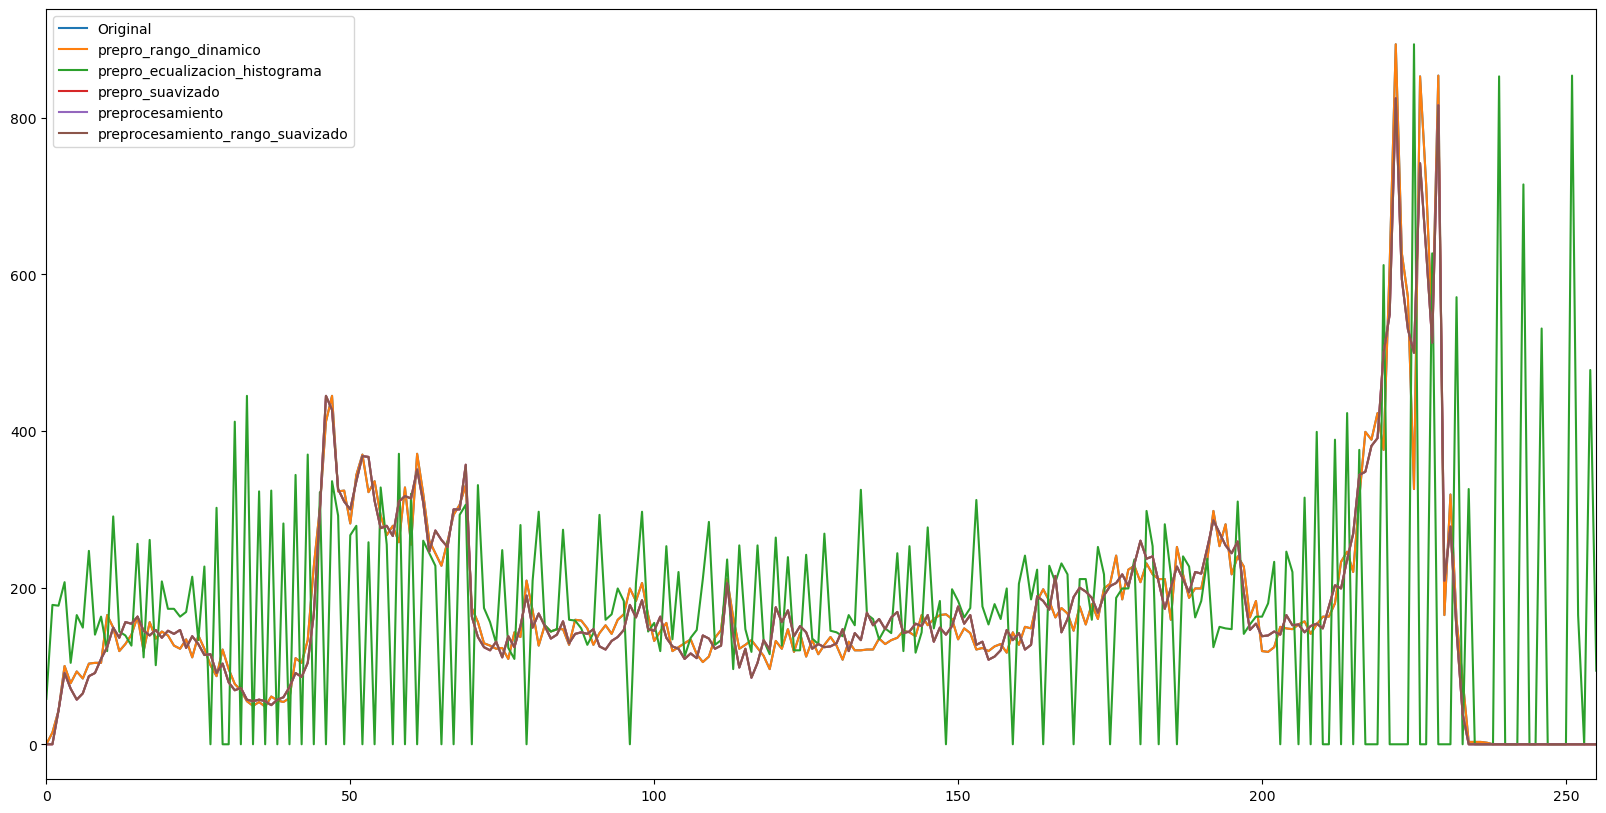

In [7]:

imagen = cv2.imread('dataset/cat_dog_100/train/cat/cat.0.jpg',0)

tecnicas_pre = [prepro_rango_dinamico,prepro_ecualizacion_histograma,prepro_suavizado,preprocesamiento,preprocesamiento_rango_suavizado] 

fig, ax = plt.subplots(figsize=(20, 10))

mostrarHistograma(modificarImagen(imagen, resolucion), ax=ax, etiqueta="Original")

for i,tecnica in enumerate(tecnicas_pre):
    imagen2 = tecnica(modificarImagen(imagen,resolucion))
    mostrarHistograma(imagen2, ax=ax, etiqueta=tecnica.__name__)

ax.legend()


In [8]:
muestra(preprocesamiento(imagen))

# Fase de Extracción de Características

### Histograma de gradientes orientados (HOG)

In [9]:
def gradiente(imagen):
    imagen_x = cv2.Sobel(imagen, cv2.CV_32F,1,0,ksize = 1)
    imagen_y = cv2.Sobel(imagen, cv2.CV_32F,0,1,ksize = 1)

    E = np.sqrt(np.power(imagen_x, 2) + np.power(imagen_y, 2))
    Phi = np.arctan2(imagen_y, imagen_x)
    Phi = np.rad2deg(Phi)

    return np.uint8(E), np.uint8(Phi)

In [10]:
def histogramasXceldas(imagen, num, E, phi):
    filas, columnas = imagen.shape
    histogramas = []
    for i in range(0, filas, num):
        for j in range(0, filas, num):
            celdaMag = E[i:i+num,j:j+num].flatten()
            celdaOri = phi[i:i+num,j:j+num].flatten()
            h = np.zeros(9)
            indices = celdaOri//(360//9)
            
            h = np.bincount(indices, weights=celdaMag, minlength=9)
            
            h = h/(np.sqrt(np.sum(h ** 2))+1e-6)
            histogramas.append(h)
    return histogramas
            

In [11]:
def extraccionCaracteristicas(imagen, num):
    imagen = np.float32(imagen)
    E, phi = gradiente(imagen)
    caracteristicas = np.concatenate(histogramasXceldas(imagen, num, E, phi))
    return caracteristicas


### Extracción de características utilizando puntos singulares

In [12]:
def puntosSingulares(imagen):
    imagen = np.float32(imagen)
    dst = cv2.cornerHarris(imagen,2,3,0.04)
    dst = cv2.dilate(dst,None)
    mask = (dst>0.01*dst.max())
 
    return mask

def extraccionCaracteristicasPuntos(imagen,num):
    mask = puntosSingulares(imagen)
    imagen = np.float32(imagen)
    E, phi = gradiente(imagen)
    E = E * mask  
    phi = phi * mask 
    caracteristicas = np.concatenate(histogramasXceldas(imagen, num, E, phi))

    return caracteristicas


### Extracción de características utilizando puntos singulares (espacial)

In [13]:
def extraccionCaracteristicasPuntosEspacial(imagen,num):
    mask = puntosSingulares(imagen)
    coordenadas = np.argwhere(mask == 1)

    filas, columnas = imagen.shape
    hist = np.zeros((num, num))

    for y, x in coordenadas:

        grad_y, grad_x = y * num // columnas, x * num // filas

        hist[grad_y, grad_x] += 1
    
    caracteristicas = hist.flatten()
    caracteristicas = caracteristicas / np.linalg.norm(caracteristicas)

    return caracteristicas


# Fase de entrenamiento del modelo

### Definición de las listas de parametros

In [15]:

# Lista de preprocesamientos y métodos de extracción de características
preprocesamientos = [
    #sin_preprocesamiento,
    #prepro_rango_dinamico,
    #prepro_ecualizacion_histograma,
    #prepro_suavizado,
    #gamma_2_0,
    preprocesamiento,
    #preprocesamiento_rango_suavizado
]

extractores = [
    extraccionCaracteristicas,
    extraccionCaracteristicasPuntos, 
    extraccionCaracteristicasPuntosEspacial
]

#Modelos
modelos_parametros = [
    {
        "modelo": make_pipeline(StandardScaler(), SVC()),
        "param_grid": {
            'svc__C': [1, 10,100],
            'svc__kernel': ['linear']
        }
    },
    {
        "modelo": make_pipeline(StandardScaler(), MLPClassifier(max_iter=200, random_state=42)),
        "param_grid": {
            'mlpclassifier__hidden_layer_sizes': [(50,), (25,25,), (50,50,25,)],
            'mlpclassifier__activation': ['relu']
        }
    }
]

### Cargar imagenes y etiquetas

In [16]:
def cargar_imagenes_y_labels(pathfile, preprocesamiento, extractor):
    X, y = [], []
    clases = ['cat', 'dog']

    for clase in clases:
        ruta = os.path.join(pathfile, clase)
        archivos = glob.glob(os.path.join(ruta, "*.jpg"))
        for archivo in archivos:
            imagen = cv2.imread(archivo, 0)
            imagen = preprocesamiento(imagen)
            caracteristicas = extractor(imagen,16)
            X.append(caracteristicas)
            y.append(0 if clase == 'cat' else 1)

    return np.array(X), np.array(y)

### Entrenamiento y selección del mejor modelo

In [17]:
def evaluar_combinaciones(dataset_path):
    mejor_puntaje = 0
    mejor_combinacion = None

    for preprocesamiento in preprocesamientos:
        for extractor in extractores:
            for modelo_param in modelos_parametros:
                modelo = modelo_param["modelo"]
                param_grid = modelo_param["param_grid"]

                prepro_nombre = preprocesamiento.__name__ 
                extractor_nombre = extractor.__name__ 
                modelo_nombre = type(modelo.steps[-1][1]).__name__

                print(f"Evaluando combinación: {prepro_nombre}, {extractor_nombre}, {modelo_nombre}")
                
                # Cargar datos de entrenamiento desde la carpeta train
                X_train, y_train = cargar_imagenes_y_labels(os.path.join(dataset_path, 'train'), preprocesamiento, extractor)
                # Cargar datos de prueba desde la carpeta test
                X_test, y_test = cargar_imagenes_y_labels(os.path.join(dataset_path, 'test'), preprocesamiento, extractor)

                # Entrenar modelo
                grid_search = GridSearchCV(modelo, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
                grid_search.fit(X_train, y_train)

                # Evaluar modelo
                y_pred = grid_search.best_estimator_.predict(X_test)
                acc = metrics.accuracy_score(y_test, y_pred)

                print(f"Accuracy: {acc:.4f}")

                if acc > mejor_puntaje:
                    mejor_puntaje = acc
                    mejor_combinacion = (prepro_nombre, extractor_nombre, modelo_nombre, grid_search.best_params_)

    print("\nMejor combinación encontrada:")
    print(f"Preprocesamiento: {mejor_combinacion[0]}")
    print(f"Extractor: {mejor_combinacion[1]}")
    print(f"Modelo: {mejor_combinacion[2]}")
    print(f"Mejores parámetros: {mejor_combinacion[3]}")
    print(f"Accuracy: {mejor_puntaje:.4f}")

# Ejecutar evaluación
evaluar_combinaciones('dataset/cat_dog_100')

Evaluando combinación: preprocesamiento, extraccionCaracteristicas, SVC
Accuracy: 0.7500
Evaluando combinación: preprocesamiento, extraccionCaracteristicas, MLPClassifier
Accuracy: 0.8000
Evaluando combinación: preprocesamiento, extraccionCaracteristicasPuntos, SVC
Accuracy: 0.8500
Evaluando combinación: preprocesamiento, extraccionCaracteristicasPuntos, MLPClassifier
Accuracy: 0.8250
Evaluando combinación: preprocesamiento, extraccionCaracteristicasPuntosEspacial, SVC
Accuracy: 0.7750
Evaluando combinación: preprocesamiento, extraccionCaracteristicasPuntosEspacial, MLPClassifier
Accuracy: 0.9750

Mejor combinación encontrada:
Preprocesamiento: preprocesamiento
Extractor: extraccionCaracteristicasPuntosEspacial
Modelo: MLPClassifier
Mejores parámetros: {'mlpclassifier__activation': 'relu', 'mlpclassifier__hidden_layer_sizes': (50,)}
Accuracy: 0.9750


In [18]:
#pruebas variando el tamaño de la resolucion y la semilla, mas explicaciones en la memoria

mejor_combinacion = [preprocesamiento, extraccionCaracteristicasPuntosEspacial]
mejor_modelo = make_pipeline(StandardScaler(), MLPClassifier(max_iter=200, random_state=42))
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,)],
    'mlpclassifier__activation': ['relu']
}


### Evaluación del modelo

In [19]:
def evaluar(dataset_path,mejor_combinacion,mejor_modelo,param_grid):

    # Cargar datos de entrenamiento desde la carpeta train
    X_train, y_train = cargar_imagenes_y_labels(os.path.join(dataset_path, 'train'), mejor_combinacion[0], mejor_combinacion[1])
    # Cargar datos de prueba desde la carpeta test
    X_test, y_test = cargar_imagenes_y_labels(os.path.join(dataset_path, 'test'), mejor_combinacion[0], mejor_combinacion[1])

    # Entrenar modelo
    grid_search = GridSearchCV(mejor_modelo, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Evaluar modelo
    y_pred = grid_search.best_estimator_.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)

    # print(f"Accuracy: {acc:.4f}")
    return acc

### Pruebas para selección de la mejor resolución

[0.65, 0.75, 0.875, 0.9, 0.85, 0.8, 0.8, 0.725, 0.75]


Text(0, 0.5, 'Precisión')

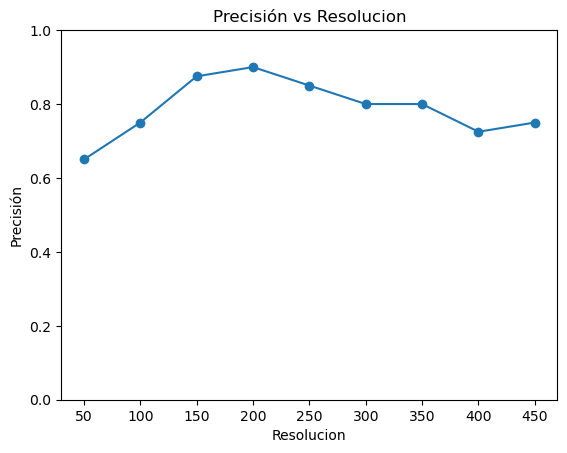

In [20]:
lista_acc1 = []
for i in range(50,500,50):
    resolucion = i
    lista_acc1.append(evaluar('dataset/cat_dog_100',mejor_combinacion,mejor_modelo,param_grid))

print(lista_acc1)
resolucion = 210 #vuelta a la normalidad

fig, ax = plt.subplots()
x = range(50,500,50)
# Graficar los datos
ax.plot(x, lista_acc1, marker='o')

# Configurar los límites del eje y para que incluyan 0 a 1
ax.set_ylim(0, 1)

# Etiquetas y título
ax.set_title("Precisión vs Resolucion")
ax.set_xlabel("Resolucion")
ax.set_ylabel("Precisión")

[0.875, 0.9, 0.95, 0.875, 0.875, 0.9, 0.975, 0.9, 0.875, 0.9]


Text(0, 0.5, 'Precisión')

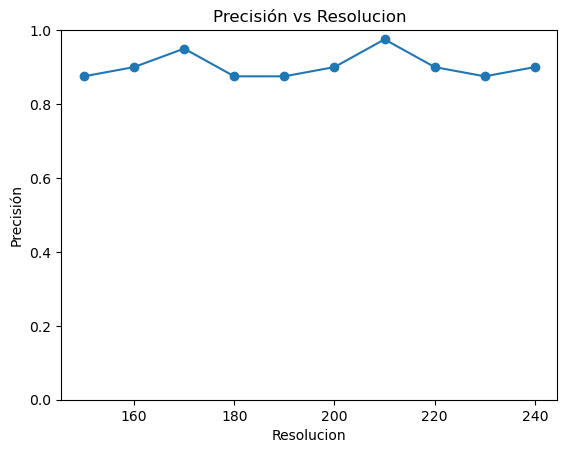

In [21]:
#buscando en un rango mas especifico

lista_acc2 = []
for i in range(150,250,10):
    resolucion = i
    lista_acc2.append(evaluar('dataset/cat_dog_100',mejor_combinacion,mejor_modelo,param_grid))

print(lista_acc2)
resolucion = 210 #vuelta a la normalidad

fig, ax = plt.subplots()
x = range(150,250,10)
# Graficar los datos
ax.plot(x, lista_acc2, marker='o')

# Configurar los límites del eje y para que incluyan 0 a 1
ax.set_ylim(0, 1)

# Etiquetas y título
ax.set_title("Precisión vs Resolucion")
ax.set_xlabel("Resolucion")
ax.set_ylabel("Precisión")

[0.8, 0.725, 0.75, 0.775, 0.75, 0.75, 0.75, 0.725]


Text(0, 0.5, 'Precisión')

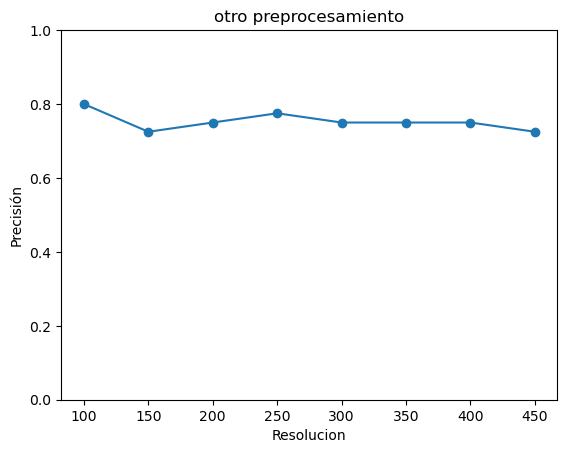

In [22]:
#con otro preprocesamiento no hay tanta variacion
combinacion = [preprocesamiento_rango_suavizado, extraccionCaracteristicasPuntosEspacial]

lista_acc3 = []
for i in range(100,500,50):
    resolucion = i
    lista_acc3.append(evaluar('dataset/cat_dog_100',combinacion,mejor_modelo,param_grid))

print(lista_acc3)
resolucion = 210 #vuelta a la normalidad

fig, ax = plt.subplots()
x = range(100,500,50)
# Graficar los datos
ax.plot(x, lista_acc3, marker='o')

# Configurar los límites del eje y para que incluyan 0 a 1
ax.set_ylim(0, 1)

# Etiquetas y título
ax.set_title("otro preprocesamiento")
ax.set_xlabel("Resolucion")
ax.set_ylabel("Precisión")

In [23]:
from collections import Counter

# Variable global para contar las veces que se pasa por cada if
estadisticas_pasos = Counter()

def preprocesamiento(imagen):  # selección automática
    global estadisticas_pasos
    estadisticas_pasos['total'] += 1
    analisis = analisisImagen(imagen)
    if analisis['std'] > 50:
        estadisticas_pasos['std > 50'] += 1
        imagen = prepro_suavizado(imagen)

    analisis = analisisImagen(imagen)
    if analisis['contraste'] < 200:
        estadisticas_pasos['contraste < 200'] += 1
        imagen = prepro_rango_dinamico(imagen)
        imagen = prepro_ecualizacion_histograma(imagen)

    analisis = analisisImagen(imagen)
    if analisis['media'] > 180:
        estadisticas_pasos['media > 180'] += 1
        imagen = prepro_gamma(imagen, 2.0)
    elif analisis['media'] < 70:
        estadisticas_pasos['media < 70'] += 1
        imagen = prepro_gamma(imagen, 0.5)

    return modificarImagen(imagen, resolucion)

mejor_combinacion = [preprocesamiento, extraccionCaracteristicasPuntosEspacial]
mejor_modelo = make_pipeline(StandardScaler(), MLPClassifier(max_iter=200, random_state=42))
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,)],
    'mlpclassifier__activation': ['relu']
}
resolucion = 210

def evaluar(dataset_path, mejor_combinacion, mejor_modelo, param_grid):
    global estadisticas_pasos

    # Reiniciar las estadísticas al inicio de la evaluación
    estadisticas_pasos = Counter()

    # Cargar datos de entrenamiento desde la carpeta train
    X_train, y_train = cargar_imagenes_y_labels(os.path.join(dataset_path, 'train'), mejor_combinacion[0], mejor_combinacion[1])
    # Cargar datos de prueba desde la carpeta test
    X_test, y_test = cargar_imagenes_y_labels(os.path.join(dataset_path, 'test'), mejor_combinacion[0], mejor_combinacion[1])

    # Entrenar modelo
    grid_search = GridSearchCV(mejor_modelo, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Evaluar modelo
    y_pred = grid_search.best_estimator_.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print("Estadísticas de preprocesamiento:")
    for paso, conteo in estadisticas_pasos.items():
        print(f"{paso}: {conteo} veces")

# Combinación exitosa
evaluar('dataset/cat_dog_100', mejor_combinacion, mejor_modelo, param_grid)
print()

# Comparativa con otra combinación no tan exitosa
combinacion = [preprocesamiento, extraccionCaracteristicas]
modelo = make_pipeline(StandardScaler(), SVC())
param_grid = {
    'svc__C': [1, 10],
    'svc__kernel': ['linear']
}
evaluar('dataset/cat_dog_100', combinacion, modelo, param_grid)

Accuracy: 0.9750
Estadísticas de preprocesamiento:
total: 240 veces
std > 50: 159 veces
contraste < 200: 12 veces
media > 180: 2 veces
media < 70: 7 veces

Accuracy: 0.7500
Estadísticas de preprocesamiento:
total: 240 veces
std > 50: 159 veces
contraste < 200: 12 veces
media > 180: 2 veces
media < 70: 7 veces
